<a href="https://colab.research.google.com/github/vineela9804/Final-project/blob/main/face_drift_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
Tesla T4


In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms


In [3]:
resnet = models.resnet50(pretrained=True)
resnet.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [1]:
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)
resnet.eval()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

lfw = fetch_lfw_people(min_faces_per_person=20, resize=0.5)

X = lfw.images          # shape: (n_samples, h, w)
y = lfw.target          # person labels

print("Images shape:", X.shape)
print("Labels shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Images shape: (3023, 62, 47)
Labels shape: (3023,)


In [5]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [7]:
import torch
import torch.nn as nn
import numpy as np

feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).cuda()
feature_extractor.eval()

sample_img = X_train[0]                     # NOW this exists
sample_img = np.stack([sample_img]*3, axis=-1)

input_tensor = preprocess(sample_img).unsqueeze(0).cuda()

with torch.no_grad():
    embedding = feature_extractor(input_tensor)

print(embedding.view(-1).shape)


torch.Size([2048])


In [8]:
import torch
import numpy as np

def extract_embeddings(images):
    embeddings = []
    for img in images:
        img = np.stack([img]*3, axis=-1)
        tensor = preprocess(img).unsqueeze(0).cuda()
        with torch.no_grad():
            emb = feature_extractor(tensor)
        embeddings.append(emb.view(-1).cpu().numpy())
    return np.array(embeddings)

# Baseline embeddings
baseline_embeddings = extract_embeddings(X_train[:200])

print(baseline_embeddings.shape)


(200, 2048)


In [9]:
import cv2

def add_gaussian_blur(images):
    degraded = []
    for img in images:
        blurred = cv2.GaussianBlur(img, (9,9), 0)
        degraded.append(blurred)
    return np.array(degraded)

drifted_images = add_gaussian_blur(X_test[:200])


In [10]:
drifted_embeddings = extract_embeddings(drifted_images)
print(drifted_embeddings.shape)


(200, 2048)


In [11]:
from sklearn.metrics.pairwise import cosine_distances

distances = cosine_distances(
    baseline_embeddings.mean(axis=0).reshape(1, -1),
    drifted_embeddings
)

print("Mean cosine distance:", distances.mean())


Mean cosine distance: 0.40200293


In [12]:
def calculate_psi(expected, actual, bins=10):
    psi = 0
    for i in range(expected.shape[1]):
        exp_hist, _ = np.histogram(expected[:, i], bins=bins)
        act_hist, _ = np.histogram(actual[:, i], bins=bins)

        exp_hist = exp_hist / np.sum(exp_hist)
        act_hist = act_hist / np.sum(act_hist)

        exp_hist = np.where(exp_hist == 0, 1e-6, exp_hist)
        act_hist = np.where(act_hist == 0, 1e-6, act_hist)

        psi += np.sum((exp_hist - act_hist) * np.log(exp_hist / act_hist))
    return psi

psi_score = calculate_psi(baseline_embeddings, drifted_embeddings)
print("PSI Score:", psi_score)


PSI Score: 1867.7619778402218


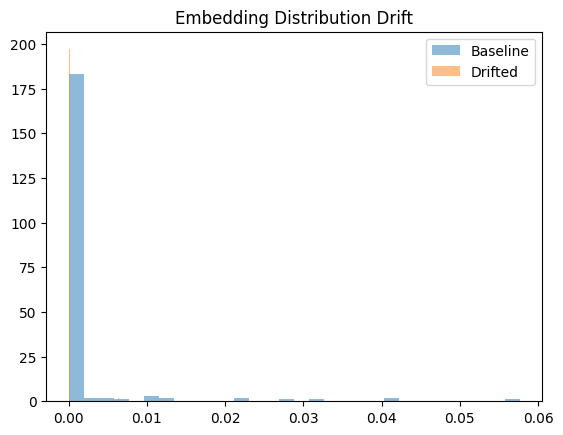

In [13]:
import matplotlib.pyplot as plt

plt.hist(baseline_embeddings[:, 0], bins=30, alpha=0.5, label="Baseline")
plt.hist(drifted_embeddings[:, 0], bins=30, alpha=0.5, label="Drifted")
plt.legend()
plt.title("Embedding Distribution Drift")
plt.show()


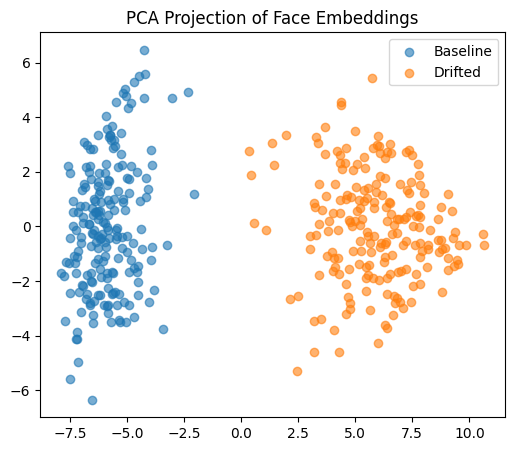

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
combined = np.vstack([baseline_embeddings, drifted_embeddings])
pca_result = pca.fit_transform(combined)

n = baseline_embeddings.shape[0]

plt.figure(figsize=(6,5))
plt.scatter(pca_result[:n, 0], pca_result[:n, 1], alpha=0.6, label="Baseline")
plt.scatter(pca_result[n:, 0], pca_result[n:, 1], alpha=0.6, label="Drifted")
plt.legend()
plt.title("PCA Projection of Face Embeddings")
plt.show()


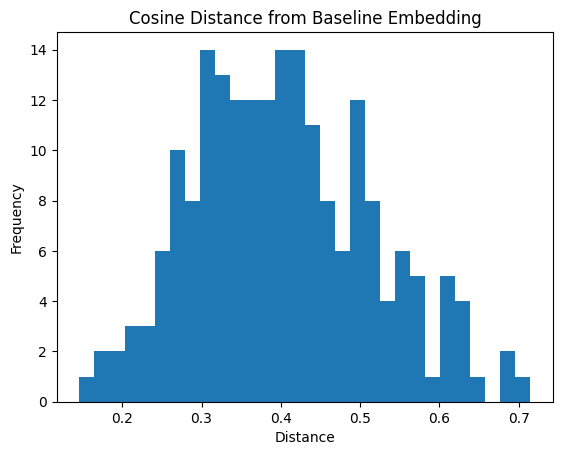

In [15]:
from sklearn.metrics.pairwise import cosine_distances

baseline_mean = baseline_embeddings.mean(axis=0).reshape(1, -1)
distances = cosine_distances(baseline_mean, drifted_embeddings)

plt.hist(distances.flatten(), bins=30)
plt.title("Cosine Distance from Baseline Embedding")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()
